# Plot figures analogue analysis (poster/presentation)

### Packages and Directories

In [1]:
# --- Imports ---
import os
import sys
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import dask
from dask.distributed import Client, LocalCluster
from scipy.interpolate import griddata
from statsmodels.stats.multitest import fdrcorrection
import calendar
from datetime import datetime, timedelta
import cftime

from scipy import ndimage

import cartopy.crs as ccrs
import cartopy.feature as cfeature

# --- Custom Functions ---
# sys.path.append('/home/portal/script/python/precip_Cristina/')                    # tintin
sys.path.append('/home/alice/Desktop/work/git/myISACcode/python/precip_Cristina')   # alice
import functions_analogues_PrMax as fanPM
import functions_analogues_LUCAFAMOSS as fan

In [17]:
# Define directories for data and figures
# # tintin
# CERRA_dir = '/work_big/users/clima/portal/CERRA-Land/'
# ERA5_dir = '/work_big/users/clima/portal/ERA5/'
# CRCM5_dir = '/work_big/users/clima/portal/CRCM5-LE/'
# fig_dir = '/home/portal/figures/analogues/'

# alice
CERRA_dir = '/media/alice/Crucial X9/portal/data_CNR/CERRA-Land/'
ERA5_dir = '/media/alice/Crucial X9/portal/data_CNR/ERA5/'
CRCM5_dir = '/media/alice/Crucial X9/portal/data_CNR/CRCM5-LE/'
fig_dir = '/home/alice/Desktop/CNR/ENCIRCLE/materiale_alice/figures/analogues/poster/'
diff_dir = './analogue_data/analogue_differences/'

### Parameters

In [18]:
# Variable
var_analogues = 'psl'  # Variable used to find the analogues, e.g. 'psl' for sea level pressure

# Quantile and analogue number
qtl_LE = 0.99
no_analogues = 18

# Number of ensemble members
no_membs = 30

# List of members
list_membs = [name for name in os.listdir(CRCM5_dir + 'psl') if os.path.isdir(os.path.join(CRCM5_dir + 'psl', name))]
list_membs = sorted(list_membs)[:no_membs]  # Select the first 'no_membs' members


In [19]:
# Event
lselect = 'alertregions'  # 'Italy' or 'wide-region' or 'alert-regions'
no_node = 1
no_event = 1
event_origin = 'CRCM5-LE'  # 'ERA5' or 'CRCM5-LE'
str_event_ERA5 = f'node{no_node}-extreme{no_event}-{lselect}'  # 'Italy' or 'wide-region' or 'alert-regions'
str_event_BAM = f'BAM-node{no_node}-extreme{no_event}-{lselect}'  # 'Italy' or 'wide-region' or 'alert-regions'

# ERA5
df_events = pd.read_excel(CERRA_dir+'events_cum_on_above99_alert_regions.xlsx', sheet_name=no_node-1)
time_ERA5event = df_events['Time'].iloc[no_event-1] + pd.Timedelta('12h')
doy_ERA5event =  time_ERA5event.timetuple().tm_yday

# BAM
BAM_info = fanPM.get_best_model_analogue_info(no_node, no_event, var_analogues)
time = datetime.strptime(BAM_info['date'], "%Y-%m-%d")
time_BAMevent = cftime.DatetimeNoLeap(time.year, time.month, time.day, hour=0, minute=0, second=0)
doy_BAMevent = time_BAMevent.timetuple().tm_yday
member_BAMevent = BAM_info['member']

# Define lon-lat box of event
box_event = fanPM.box_event_PrMax_alertregions(no_node,no_event)

# Defines the months for analogue selection
month_event = time_ERA5event.month
months_sel = [month_event-1, month_event, month_event+1]
# Get the month names
month_names = [calendar.month_abbr[month] for month in months_sel]
# Extract the initials
str_months_ERA5 = ''.join([name[0] for name in month_names])


### Plot event ERA5 (first row of figures) and BAM (second row of figures)

In [20]:
# Upload data ERA5

# mslp
dmslp_event_ERA5 = fanPM.load_ERA5_data('mslp', 'daily', time_ERA5event, box_event, l_anom=True)
mslp_clim_ERA5 = fanPM.load_ERA5_clim('mslp', doy_ERA5event, box_event, l_smoothing=True)
# Regrid 
dmslp_event_ERA5 = fanPM.regrid_with_xesmf(dmslp_event_ERA5, box_event, resolution=0.5)
mslp_clim_ERA5 = fanPM.regrid_with_xesmf(mslp_clim_ERA5, box_event, resolution=0.5)

# precip
precip_event_CERRA = fanPM.load_CERRA_precip(time_ERA5event-pd.Timedelta('18h'), box_event)

/home/alice/anaconda3/envs/xesmf_env/lib/python3.13/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/home/alice/anaconda3/envs/xesmf_env/lib/python3.13/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


In [21]:
# Upload data CRCM5
year_range_BAM = [2004,2023]
# psl
BAM_files, BAM_files_clim = fanPM.get_anomaly_climatology_paths_CRCM5_bymonth(CRCM5_dir, var_analogues, [member_BAMevent], [[time_BAMevent]])
list_ds = fanPM.open_member_datasets(BAM_files, combine='by_coords', expand_member_dim=True)
list_ds_clim = fanPM.open_member_datasets(BAM_files_clim, combine='by_coords', expand_member_dim=True)
dmslp_BAM = xr.concat(list_ds, dim='member')['psl'] * 0.01
mslp_BAM = xr.concat(list_ds_clim, dim='member')['psl'] * 0.01
# Select the time of the event
dmslp_BAM = dmslp_BAM.sel(time=time_BAMevent).squeeze('member')
doy_clim = mslp_BAM.time.dt.dayofyear.values
mask_time = doy_clim == doy_BAMevent
mslp_BAM = mslp_BAM.sel(time=mask_time).squeeze('time').squeeze('member')

# precip
precip_files = fanPM.get_precipitation_paths_CRCM5_bymonth(CRCM5_dir, [member_BAMevent], [[time_BAMevent]])
# Make list of datasets and add 'member' coordinate
list_ds = fanPM.open_member_datasets(precip_files, combine='by_coords', expand_member_dim=True)
# Concatenate, scale, choose date and select box
pr_tmp = xr.concat(list_ds, dim='member')['pr'] * 3600 # Convert from mm/s*24 to mm/day
pr_BAM = pr_tmp.sel(time=time_BAMevent + timedelta(hours=12)).squeeze('member')

# Select lon lat mask for the event
lon_mask, lat_mask = fanPM.lonlat_mask(dmslp_BAM.lon.values, dmslp_BAM.lat.values, box_event)
mask_BAM = lat_mask[:, np.newaxis] & lon_mask
mask_xr_BAM = xr.DataArray(
    mask_BAM,
    dims=["lat", "lon"],
    coords={"lat": dmslp_BAM.lat.values, "lon": dmslp_BAM.lon.values},
)

# Apply mask
dmslp_BAM = dmslp_BAM.where(mask_xr_BAM, drop=True)
mslp_BAM = mslp_BAM.where(mask_xr_BAM, drop=True)
pr_BAM = pr_BAM.where(mask_xr_BAM, drop=True)

Opening files for member: kbw
Opening files for member: kbw
Opening files for member: kbw


In [22]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from cartopy.util import add_cyclic_point

def _apply_common_map_style(ax, lonlat_bounds=None, title=None):
    """Applies consistent coastlines, borders, gridlines, extent, and title."""
    ax.coastlines(linewidth=1.2)
    # ax.add_feature(cfeature.BORDERS, linewidth=0.8)
    if lonlat_bounds is not None:
        ax.set_extent(lonlat_bounds, crs=ccrs.PlateCarree())

    gl = ax.gridlines(
        draw_labels=True, linestyle="--", color="gray", alpha=0.5, linewidth=0.7
    )
    gl.top_labels = False
    gl.right_labels = False

    if title:
        ax.set_title(title, fontsize=12, weight="bold")

    return ax


def plot_precipitation(ax, lonlat_bounds, precip, precip_levels, title):
    """Plots the precipitation data for a given timestep."""

    lon = precip.lon.values
    lat = precip.lat.values
    precip, lon1 = add_cyclic_point(precip, coord=lon)

    # Apply uniform style
    _apply_common_map_style(ax, lonlat_bounds, title)

    # Colormap settings
    if np.any(precip_levels<0):
        cmap = plt.get_cmap("Spectral")  
        cbar_ext = 'both'
    else:
        cmap = plt.get_cmap("YlGnBu")
        cbar_ext = "max"
    norm = mcolors.BoundaryNorm(boundaries=precip_levels, ncolors=cmap.N, extend=cbar_ext)

    # Plot precipitation
    mesh = ax.pcolormesh(
        lon1, lat, precip, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm
    )

    # Colorbar
    cbar = plt.colorbar(
        mesh,
        ax=ax,
        orientation="vertical",
        pad=0.05,
        boundaries=precip_levels,
        extend=cbar_ext,
        shrink=0.8,
    )
    cbar.set_label("24h precipitation [mm]", fontsize=10)


def plot_anom_event(ax, varname, lon, lat, anom_event, clim, title, levels=None):
    """Plots the anomaly and DOY climatology for a given event (mslp or z500)."""

    # Set variable-specific intervals
    if varname == "z500":
        cbar_int = 50
        levels_clim = np.arange(5000, 6000, 25)
        cbar_label = "$\\Delta$Z500 (m)"
    elif varname == "mslp":
        cbar_int = 2
        levels_clim = np.arange(950, 1050, 1)
        cbar_label = "$\\Delta$mslp (hPa)"

    # Symmetric colorbar range
    if levels is not None:
        cbar_levels = levels
    else:
        vmin, vmax = np.nanmin(anom_event), np.nanmax(anom_event)
        cbar_center = max(abs(vmin), abs(vmax)) // cbar_int * cbar_int + cbar_int
        cbar_levels = np.arange(-cbar_center, cbar_center + cbar_int, cbar_int)
        
    # Apply uniform style
    _apply_common_map_style(ax, title=title)

    # Filled anomalies
    cf = ax.contourf(
        lon,
        lat,
        anom_event,
        transform=ccrs.PlateCarree(),
        cmap="RdBu_r",
        levels=cbar_levels,
        extend="both",
    )
    # Climatology contours
    contours = ax.contour(
        lon,
        lat,
        clim,
        transform=ccrs.PlateCarree(),
        levels=levels_clim,
        colors="black",
        linewidths=0.8,
    )
    ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")

    # Colorbar
    plt.colorbar(cf, ax=ax, shrink=0.8, label=cbar_label)
    return ax

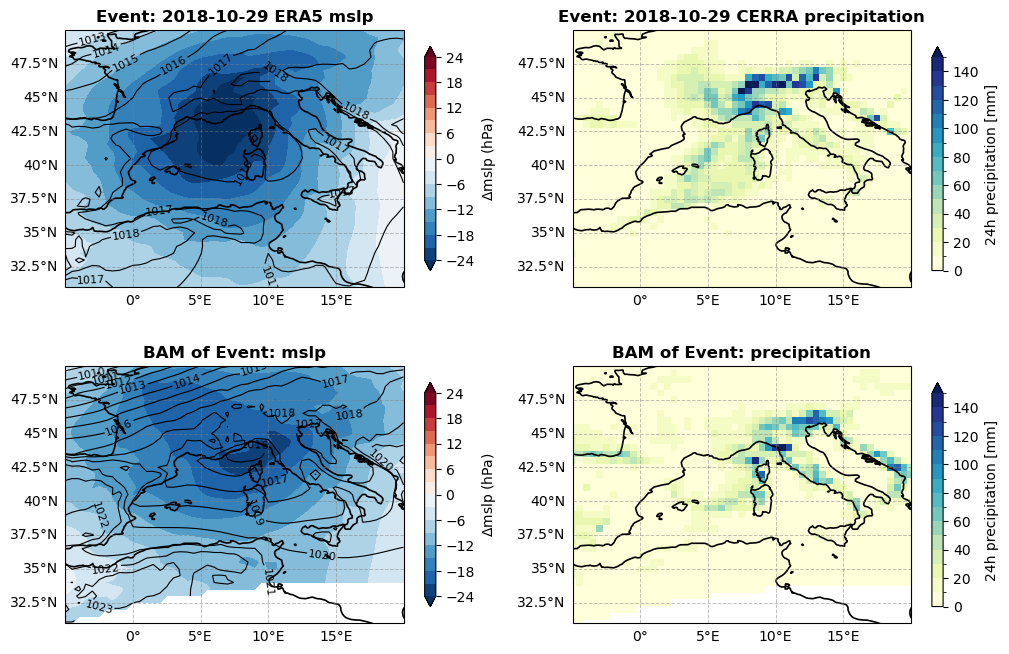

In [23]:
fig, ax = plt.subplots(
    nrows=2, ncols=2, figsize=(12, 8),
    subplot_kw={'projection': ccrs.PlateCarree()}
    )
ax = ax.ravel()

# Plot ERA5 mslp
dmslp_levels = np.arange(-24,25,3)
plot_anom_event(ax[0], 'mslp', dmslp_event_ERA5.lon, dmslp_event_ERA5.lat, dmslp_event_ERA5, mslp_clim_ERA5, f'Event: {time_ERA5event.strftime("%Y-%m-%d")} ERA5 mslp', levels=dmslp_levels)
plot_anom_event(ax[2], 'mslp', dmslp_BAM.lon, dmslp_BAM.lat, dmslp_BAM, mslp_BAM, 'BAM of Event: mslp', levels=dmslp_levels)

# Plot BAM precipitation
plot_precipitation(ax[1], box_event, precip_event_CERRA, 
                         precip_levels=np.arange(0, 155, 10), title=f'Event: {time_ERA5event.strftime("%Y-%m-%d")} CERRA precipitation')
timestr_BAMevent = str(pr_BAM.time.dt.strftime("%Y-%m-%d %H:%M UTC").values)[:10]
plot_precipitation(ax[3], box_event, pr_BAM, 
                         precip_levels=np.arange(0, 155, 10), title='BAM of Event: precipitation')

# Save the figure
fig.savefig(f"{fig_dir}mslp_pr_BAM-{var_analogues}_node{no_node}_extreme{no_event}-alertregions_{str_months_ERA5}_{year_range_BAM[0]}-{year_range_BAM[1]}_CRCM5-LE_{no_membs}membs.png", bbox_inches='tight', dpi=300)

### Plot analogue mean in different epochs (30 members)

In [24]:
# Variable
varname = 'psl'

# List epochs
list_year_ranges = [[1955, 1974], [2004, 2023], [2080, 2099]] # past [1955-1974], present [2004-2023], near-future [2030-2049], far future [2080-2099]
no_epochs = len(list_year_ranges)


In [25]:
# Upload analogue data
list_ds_anom = []  # List to store difference datasets
list_ds_clim = []  # List to store difference datasets
for i in range(no_epochs):
    year_range = list_year_ranges[i]
    str_year_range = "-".join(str(x) for x in year_range)
    suffix_file = f"_{varname}_{str_event_BAM}_{int(100*qtl_LE)}pct_{str_year_range}_CRCM5_{no_membs}membs.nc"
        
    # Load analogue anomalies
    anom_file = f'{diff_dir}analogues-{var_analogues}_anomaly{suffix_file}'
    if not os.path.exists(anom_file):
        print(f'File {anom_file} does not exist. Skipping epoch {i+1}.')
        continue
    ds_anom = xr.open_dataset(anom_file)
    list_ds_anom.append(ds_anom)

    # Load climatologies
    clim_file = f'{diff_dir}analogues-{var_analogues}_climatology{suffix_file}'
    if not os.path.exists(clim_file):
        print(f'File {clim_file} does not exist. Skipping epoch {i+1}.')
        continue
    ds_clim = xr.open_dataset(clim_file)
    list_ds_clim.append(ds_clim)

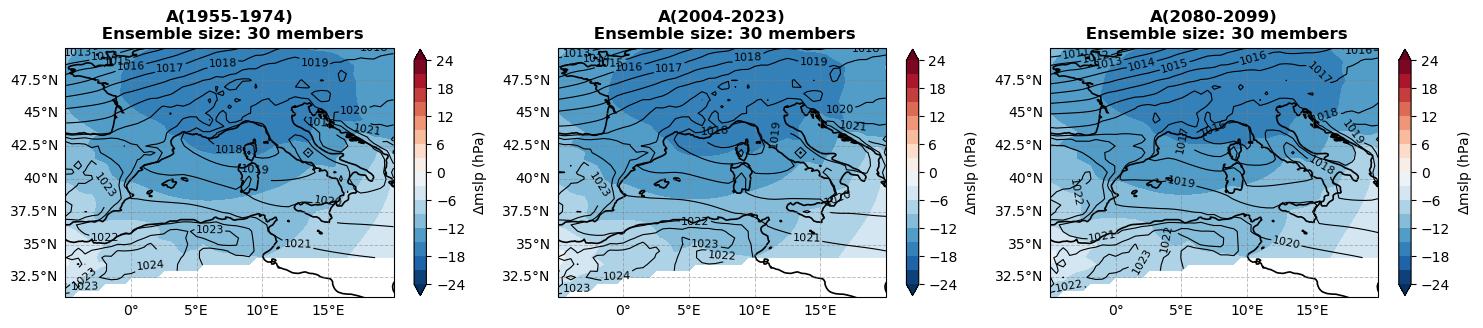

In [26]:
fig, ax = plt.subplots(
    nrows=1, ncols=no_epochs, figsize=(6*no_epochs, 4),
    sharey=True,
    subplot_kw={'projection': ccrs.PlateCarree()}
    )
ax = ax.ravel()

# Plot
for i in range(no_epochs):
    plot_anom_event(
        ax[i], 'mslp', 
        list_ds_anom[i].lon, list_ds_anom[i].lat, 
        list_ds_anom[i][varname], list_ds_clim[i][varname], 
        f'A({list_year_ranges[i][0]}-{list_year_ranges[i][1]})\n Ensemble size: {no_membs} members',
        levels=np.arange(-24, 25, 3)
    )
# fig.suptitle(f'Composites of BAM analogues ({no_membs} members)', fontsize=12, fontweight='bold')

# Save the figure
fig.savefig(f"{fig_dir}{varname}_analogue-anomalies-{var_analogues}_{str_event_BAM}_{int(qtl_LE*100)}pct_CRCM5_{no_membs}membs.png", bbox_inches='tight', dpi=300)

In [27]:
# Variable
varname = 'pr'
factor = 3600

# Upload analogue data
list_ds = []  # List to store difference datasets
for i in range(no_epochs):
    year_range = list_year_ranges[i]
    str_year_range = "-".join(str(x) for x in year_range)
    suffix_file = f"{varname}_{str_event_BAM}_{int(100*qtl_LE)}pct_{str_year_range}_CRCM5_{no_membs}membs.nc"
        
    # Load analogue anomalies
    file = f'{diff_dir}analogues-{var_analogues}_{suffix_file}'
    if not os.path.exists(file):
        print(f'File {file} does not exist. Skipping epoch {i+1}.')
        continue
    ds = xr.open_dataset(file)
    list_ds.append(ds)

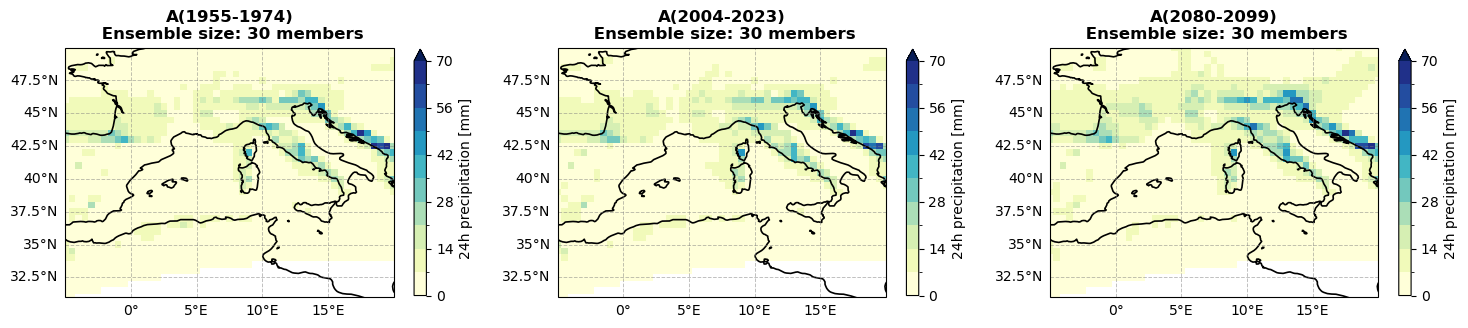

In [28]:
fig, ax = plt.subplots(
    nrows=1, ncols=no_epochs, figsize=(6*no_epochs, 4),
    sharey=True,
    subplot_kw={'projection': ccrs.PlateCarree()}
    )
ax = ax.ravel()

# Plot
for i in range(no_epochs):
    plot_precipitation(
        ax[i], box_event, 
        list_ds[i][varname]*factor,
        np.arange(0, 77, 7),
        f'A({list_year_ranges[i][0]}-{list_year_ranges[i][1]})\n Ensemble size: {no_membs} members',
    )
# fig.suptitle(f'composites of BAM analogues ({no_membs} members)', fontsize=16)

# Save the figure
fig.savefig(f"{fig_dir}{varname}_analogues-{var_analogues}_{str_event_BAM}_{int(qtl_LE*100)}pct_CRCM5_{no_membs}membs.png", bbox_inches='tight', dpi=300)

### Plot precipitation difference between different epochs and using different ensemble sizes

In [29]:
# Parameters
# Variable
varname = 'pr'
factor = 3600

# Difference between epochs
list_diff_indices = [[0,1],[1,2], [0,2]]  # Define the indices of epochs to compare

# List of ensemble sizes (by no members considered)
list_size_ens = [1, 5, 30]
str_size_ens = ''
for se in list_size_ens:
    str_size_ens += f'{se}-'
str_size_ens = str_size_ens[:-1] + 'membs'
print(str_size_ens)

1-5-30membs


In [30]:
list_ds_diff = []  # List to store difference datasets
list_str_diff = []  # List to store strinlist_membs[19]g representations of differences
list_ds_ks_stats = []  # List to store KS statistics datasets
for no_membs in list_size_ens:
    for i in range(len(list_diff_indices)):
        year_range1 = list_year_ranges[list_diff_indices[i][0]]
        str_year_range1 = "-".join(str(x) for x in year_range1)
        year_range2 = list_year_ranges[list_diff_indices[i][1]]
        str_year_range2 = "-".join(str(x) for x in year_range2)
        list_str_diff.append(f'{str_year_range2} - {str_year_range1}')  # Store the string representation of the difference
        suffix_file = f"_{varname}_{str_event_BAM}_{int(100*qtl_LE)}pct_diff{str_year_range2}_{str_year_range1}_CRCM5_{no_membs}membs.nc"
            
        # Load analogue differences
        diff_file = f'{diff_dir}analogues-{var_analogues}_difference{suffix_file}'
        if not os.path.exists(diff_file):
            print(f'File {diff_file} does not exist. Skipping epoch {i+1}.')
            continue
        ds_diff = xr.open_dataset(diff_file)
        list_ds_diff.append(ds_diff)
        # Load KS statistics
        significance_file = f'{diff_dir}analogues-{var_analogues}_KS-statistics{suffix_file}'
        if not os.path.exists(significance_file):
            print(f'File {significance_file} does not exist. Skipping epoch {i+1}.')
            continue
        ds_ks_stats = xr.open_dataset(significance_file)
        list_ds_ks_stats.append(ds_ks_stats)

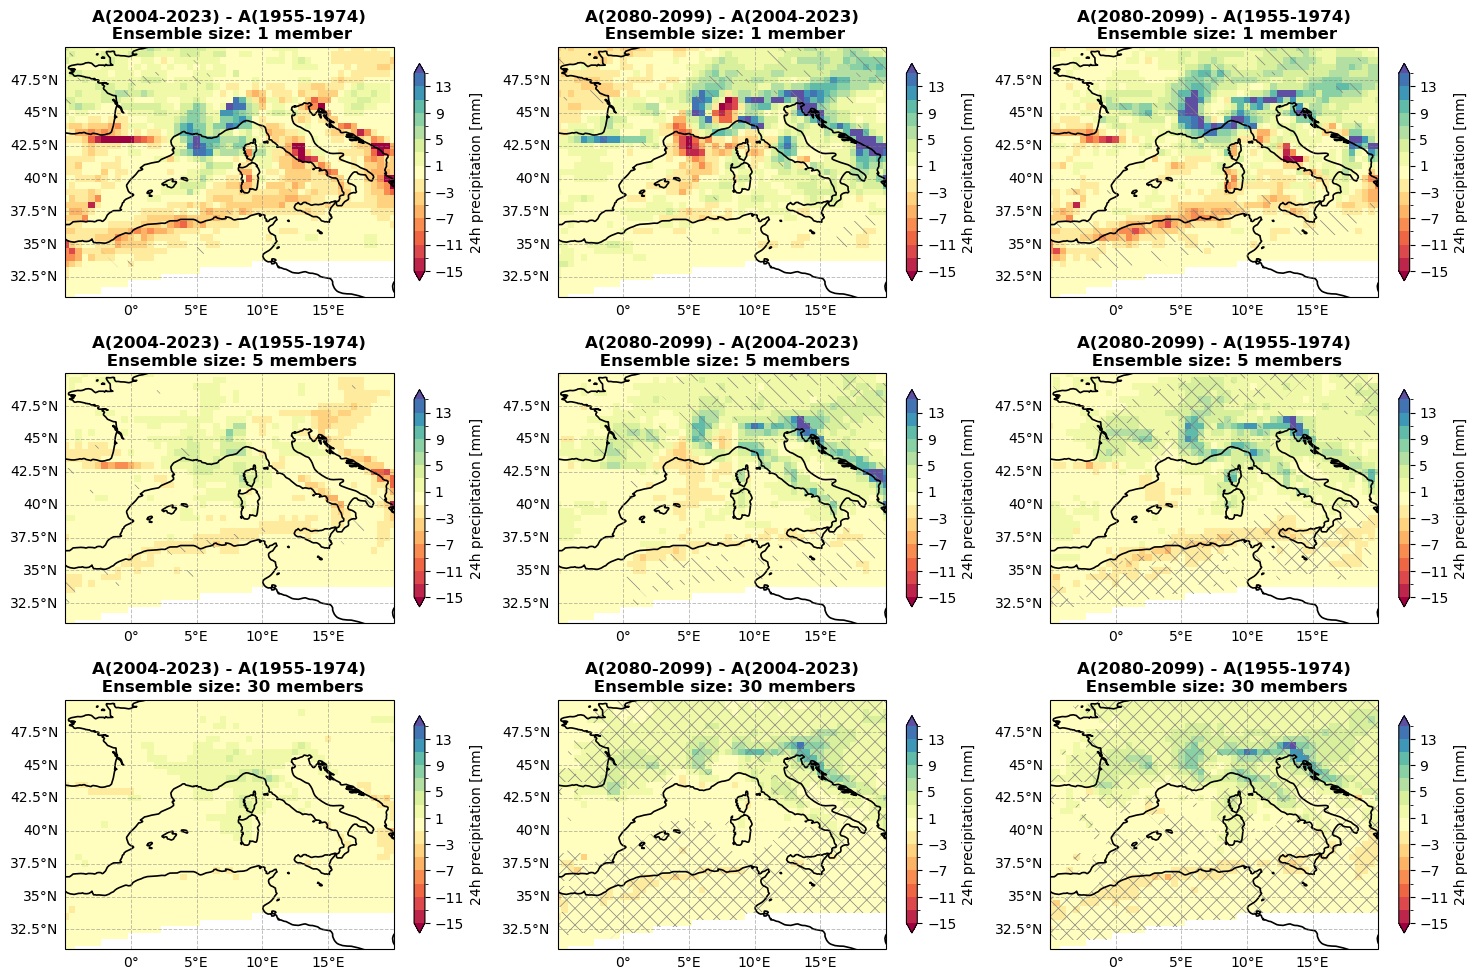

In [31]:
# Plot difference (columns of epoch differences, rows of ensemble sizes)
no_diff = len(list_diff_indices)
no_size = len(list_size_ens)
fig, ax = plt.subplots(nrows=no_size, ncols=no_diff, 
                       figsize=(no_diff * 6, no_size * 4),
                       sharex=True, sharey=True,
                       subplot_kw={'projection': ccrs.PlateCarree()}
                       )
ax = ax.ravel()

for i in range(no_size):
    for j in range(no_diff):
        k = i*no_diff + j
        # Plot the difference for each ensemble size and epoch difference
        ds_diff = list_ds_diff[k]
        ds_ks_stats = list_ds_ks_stats[k]
        p_values = ds_ks_stats.sel(output='pvalue').squeeze()[varname].values
        str_year_range1 = f"{list_year_ranges[list_diff_indices[j][0]][0]}-{list_year_ranges[list_diff_indices[j][0]][1]}"
        str_year_range2 = f"{list_year_ranges[list_diff_indices[j][1]][0]}-{list_year_ranges[list_diff_indices[j][1]][1]}"
        if list_size_ens[i]==1:
            subtitle = f'A({str_year_range2}) - A({str_year_range1})\n Ensemble size: {list_size_ens[i]} member'
        else:
            subtitle = f'A({str_year_range2}) - A({str_year_range1})\n Ensemble size: {list_size_ens[i]} members'
        plot_precipitation(ax[k], box_event, ds_diff['pr']*factor, 
                           precip_levels=np.arange(-15, 16, 2), title=subtitle)
        # 
        # Flatten while ignoring NaNs
        mask = ~np.isnan(p_values)
        pvals_flat = p_values[mask]
        # Apply FDR correction
        rejected, pvals_corrected = fdrcorrection(pvals_flat, alpha=0.05)
        # Put results back into 2D arrays, filling NaNs where appropriate
        rejected_2d = np.full(p_values.shape, np.nan)
        rejected_2d[mask] = rejected
        pvals_corrected_2d = np.full(p_values.shape, np.nan)
        pvals_corrected_2d[mask] = pvals_corrected
        # Hatching where significant
        significant_mask_corrected = pvals_corrected_2d < 0.05
        significant_mask = p_values < 0.05
        # Contour significant areas
        plt.rcParams['hatch.linewidth'] = 0.5   # thinner lines
        plt.rcParams['hatch.color'] = 'grey'
        ax[k].contourf(
            ds_diff['lon'], ds_diff['lat'], significant_mask_corrected,
            levels=[0.5, 1.5], 
            colors='none',      # no fill color
            hatches=['//'],
            transform=ccrs.PlateCarree()
        )
        ax[k].contourf(
            ds_diff['lon'], ds_diff['lat'], significant_mask,
            levels=[0.5, 1.5], 
            colors='none',      # no fill color
            hatches=['\\\\'],
            transform=ccrs.PlateCarree()
        )
fig.savefig(f"{fig_dir}{varname}_analogue-differences-{var_analogues}_{str_event_BAM}_{int(qtl_LE*100)}pct_CRCM5_{str_size_ens}.png", bbox_inches='tight', dpi=300)

#### Average in mask

In [32]:
# Upload analogue data
list_ds_reg = []  # List to store difference datasets
list_stats_past = []  # List to store statistics for past epochs
list_stats_future = []  # List to store statistics for future epochs
for i in range(no_size):
    no_membs = list_size_ens[i]
    for j in range(no_epochs):
        year_range = list_year_ranges[j]
        str_year_range = "-".join(str(x) for x in year_range)
        suffix_file = f"{varname}_{str_event_BAM}_{int(100*qtl_LE)}pct_{str_year_range}_CRCM5_{no_membs}membs.nc"

        # Load analogue anomalies
        file = f'{diff_dir}analogues-{var_analogues}_mask-mean-{suffix_file}'
        if not os.path.exists(file):
            print(f'File {file} does not exist. Skipping epoch {j+1}.')
            continue
        ds = xr.open_dataset(file)
        list_ds_reg.append(ds)

    # Compute p-val using KS test
    arr_past = list_ds_reg[-3]['pr'].values.flatten()
    arr_past = arr_past[~np.isnan(arr_past)]
    arr_present = list_ds_reg[-2]['pr'].values.flatten()
    arr_present = arr_present[~np.isnan(arr_present)]
    arr_future = list_ds_reg[-1]['pr'].values.flatten()
    arr_future = arr_future[~np.isnan(arr_future)]
    list_stats_past.append(fanPM.ks_stat_and_pval(arr_past, arr_present))
    list_stats_future.append(fanPM.ks_stat_and_pval(arr_present, arr_future))


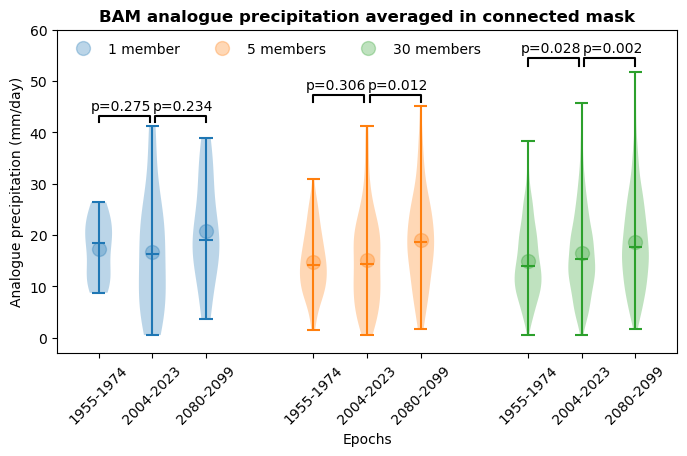

In [33]:
# Plot violin plots per epoch, once per ensemble size

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4.2))
ax.set_title(f"BAM analogue precipitation averaged in connected mask", fontsize=12, weight="bold")

# Violin plot setup
list_epoch_str = [f"{year_range[0]}-{year_range[1]}" for year_range in list_year_ranges]

for i in range(no_size):
    # Get the data for the current epoch and ensemble size
    list_reg_precip = list_ds_reg[i*no_epochs:(i+1)*no_epochs]
    # Plot the violin for the current epoch and ensemble size
    reg_precip_clean = [np.array(x[varname].values)[~np.isnan(x[varname].values)]*factor for x in list_reg_precip]
    violin = ax.violinplot(reg_precip_clean, positions=1+i*4+np.arange(no_epochs),showmeans=False, showmedians=True, showextrema=True)
    # Plot the mean precipitation for the epoch
    violin_color = violin['bodies'][0].get_facecolor().flatten()
    no_membs = list_size_ens[i]
    if no_membs == 1:
        plot_label = f'{no_membs} member'
    else:
        plot_label = f'{no_membs} members'
    ax.plot(1+i*4+np.arange(no_epochs), [np.mean(reg_precip_clean[j]) for j in range(len(reg_precip_clean))], marker='o', color=violin_color, markersize=10, label=plot_label, linewidth=0)
    
    # Add p-value
    p_past = list_stats_past[i][1]
    p_future = list_stats_future[i][1]
    # Get x positions of the two violins
    x1 = 1 + i*4 + 0              # first violin position
    x2a = 1 + i*4 + 0.95              # second violin position
    x2b = 1 + i*4 + 1.05
    x3 = 1 + i*4 + 2              # third violin position
    y_max = max([np.max(reg_precip_clean[j]) for j in range(no_epochs)])  # highest point for vertical placement
    # Draw a bracket line
    ax.plot([x1, x1, x2a, x2a], [y_max*1.02, y_max*1.05, y_max*1.05, y_max*1.02], color="black")
    ax.plot([x2b, x2b, x3, x3], [y_max*1.02, y_max*1.05, y_max*1.05, y_max*1.02], color="black")
    # Add the p-value text above
    ax.text((3*x1+2*x2b)/5, y_max*1.06, f"p={p_past:.3f}", ha="center", va="bottom", fontsize=10, color="black")
    ax.text((2*x2a+3*x3)/5, y_max*1.06, f"p={p_future:.3f}", ha="center", va="bottom", fontsize=10, color="black")
# Ticks and labels
ax.set_xticks(range(1, no_size*(no_epochs + 1)))
list_epoch_ticks = []
xticks = []
for i in range(no_size):
    xticks.extend([1+i*4+j for j in range(no_epochs)])
    list_epoch_ticks.extend(list_epoch_str)
ax.set_ylim(-3,60)
ax.set_xticks(xticks)
ax.set_xticklabels(list_epoch_ticks, rotation=45)
ax.set_xlabel('Epochs')
ax.set_ylabel('Analogue precipitation (mm/day)')
ax.legend(ncol=3, frameon=False) 




plt.show()

# Save the figure
fig.savefig(f"{fig_dir}{varname}_mask-mean_analogues-{var_analogues}_{str_event_BAM}_{int(qtl_LE*100)}pct_CRCM5_{str_size_ens}.png", bbox_inches='tight', dpi=300)